# Using `create_missingness_prop_matrix`: A Complete Guide

The `create_missingness_prop_matrix()` function creates a matrix showing the proportion of missing values for each sample–feature combination across multiple timepoints. This matrix can then be used for **sample clustering** with `cluster_on_missing_prop()` or as input to the complete CISS-VAE pipeline via `run_cissvae()`.

## Overview

The function returns a **n_samples × n_features** matrix where each cell contains a value between 0 and 1 representing:

```
proportion = (number of missing timepoints) / (total timepoints)
```

- **0.0** = no missing values for that sample-feature combination
- **1.0** = all timepoints missing for that sample-feature combination

## Data Format Support

The function supports two input formats:

### 1. **Wide Format** (default)
Columns represent feature×timepoint combinations, rows represent samples.

### 2. **Long Format** 
Each row represents one sample/feature/timepoint observation.

---

## Wide Format Examples

### Example 1: Basic Wide Format with Regex Parsing

In [1]:
import pandas as pd
import numpy as np
from ciss_vae.utils.matrix import create_missingness_prop_matrix

# Create sample wide-format data
# Columns follow pattern: feature_timepoint
data_wide = pd.DataFrame({
    'sample_id': ['mouse1', 'mouse2', 'mouse3'],
    'glucose_t0': [100, 95, np.nan],
    'glucose_t1': [110, np.nan, 105],
    'glucose_t2': [np.nan, 100, 115],
    'insulin_t0': [5.2, 4.8, 5.0],
    'insulin_t1': [np.nan, np.nan, 5.5],
    'insulin_t2': [6.0, 5.1, np.nan]
})

print(f"Data: \n{data_wide}\n\n")

# Basic usage - regex automatically extracts features
prop_matrix = create_missingness_prop_matrix(
    data_wide,
    index_col="sample_id",
    repeat_feature_names = ["glucose", "insulin"],
    timepoint_prefix = "t"
)

print(f"Output: \n{prop_matrix}")

Data: 
  sample_id  glucose_t0  glucose_t1  glucose_t2  insulin_t0  insulin_t1  \
0    mouse1       100.0       110.0         NaN         5.2         NaN   
1    mouse2        95.0         NaN       100.0         4.8         NaN   
2    mouse3         NaN       105.0       115.0         5.0         5.5   

   insulin_t2  
0         6.0  
1         5.1  
2         NaN  


Output: 
         glucose   insulin
mouse1  0.333333  0.333333
mouse2  0.333333  0.333333
mouse3  0.333333  0.333333


### Example 2: Custom Regex Pattern

In [2]:
# Data with different naming convention: feature.timepoint
data_custom = pd.DataFrame({
    'ID': ['A', 'B', 'C'],
    'weight_day1': [25.0, np.nan, 27.0],
    'weight_day7': [24.5, 26.0, np.nan],
    'height_day1': [10.0, 9.5, np.nan],
    'height_day7': [10.2, np.nan, 9.8]
})

prop_matrix = create_missingness_prop_matrix(
    data_custom,
    index_col="ID",
    repeat_feature_names = ["weight", "height"],
    timepoint_prefix = "day"
)

print(f"Output: \n{prop_matrix}")

Output: 
   weight  height
A     0.0     0.0
B     0.5     0.5
C     0.5     0.5


### Example 3: Explicit Column Mapping

In [3]:
data_mixed = pd.DataFrame({
    'subject': ['S1', 'S2'],
    'baseline_glucose': [90, np.nan],
    'followup_glucose': [95, 88],
    'glucose_final': [np.nan, 92],
    'insulin_start': [4.0, 3.8],
    'insulin_end': [4.5, np.nan]
})

# Explicitly map columns to features
column_mapping = {
    "glucose": ["baseline_glucose", "followup_glucose", "glucose_final" ],
    "insulin": ["insulin_start", "insulin_end"]
}

print(data_mixed)

prop_matrix = create_missingness_prop_matrix(
    data = data_mixed,
    index_col="subject",
    column_mapping=column_mapping
)

print(f"Output: \n{prop_matrix}")

  subject  baseline_glucose  followup_glucose  glucose_final  insulin_start  insulin_end
0      S1              90.0                95            NaN            4.0          4.5
1      S2               NaN                88           92.0            3.8          NaN
Output: 
     glucose  insulin
S1  0.333333      0.0
S2  0.333333      0.5


# Integration with sample clustering 

In [4]:
from ciss_vae.utils.clustering import cluster_on_missing_prop

data_wide = pd.DataFrame({
    'sample_id':  ['mouse1', 'mouse2', 'mouse3', 'mouse4', 'mouse5'],
    'glucose_t0': [100,      95,       np.nan,   102,      98     ],
    'glucose_t1': [110,      np.nan,   105,      108,      np.nan ],
    'glucose_t2': [115,      100,      107,   118,   112    ],
    'insulin_t0': [5.2,      4.8,      np.nan,      np.nan,   5.1    ],
    'insulin_t1': [np.nan,   np.nan,   5.5,      5.3,      5.4    ],
    'insulin_t2': [6.0,      5.1,      np.nan,   np.nan,      np.nan ],
})

print(data_wide)

# Create missingness proportion matrix
prop_matrix = create_missingness_prop_matrix(
    data_wide, 
    index_col="sample_id"
)

print(prop_matrix)

# Cluster samples based on similar missingness patterns across features
clusters, silhouette = cluster_on_missing_prop(
    prop_matrix,
    n_clusters=2,
    metric="cosine",
    scale_features=True
)

print("Clusters:", clusters)
print("Silhouette score:", silhouette)

  sample_id  glucose_t0  glucose_t1  glucose_t2  insulin_t0  insulin_t1  insulin_t2
0    mouse1       100.0       110.0         115         5.2         NaN         6.0
1    mouse2        95.0         NaN         100         4.8         NaN         5.1
2    mouse3         NaN       105.0         107         NaN         5.5         NaN
3    mouse4       102.0       108.0         118         NaN         5.3         NaN
4    mouse5        98.0         NaN         112         5.1         5.4         NaN
        glucose_t0  glucose_t1  glucose_t2  insulin_t0  insulin_t1  insulin_t2
mouse1         0.0         0.0         0.0         0.0         1.0         0.0
mouse2         0.0         1.0         0.0         0.0         1.0         0.0
mouse3         1.0         0.0         0.0         1.0         0.0         1.0
mouse4         0.0         0.0         0.0         1.0         0.0         1.0
mouse5         0.0         1.0         0.0         0.0         0.0         1.0
Clusters: [0 1 0 0 1]


# Integration w/ CISS-VAE pipeline
The proportion matrix can be used directly in the complete CISS-VAE pipeline via the `missingness_proportion_matrix` parameter:

[Warning] 3 feature(s) had zero std after masking. Replaced with 1.0 to avoid div-by-zero. Features: ['glucose_t1', 'insulin_t1', 'insulin_t2']
Cluster dataset:
 ClusterDataset(n_samples=5, n_features=6, n_clusters=2)
  • Original missing: 10 / 30 (33.33%)
  • Validation held-out: 10 (50.00% of non-missing)
  • .data shape:     (5, 6)
  • .masks shape:    (5, 6)
  • .val_data shape: (5, 6)


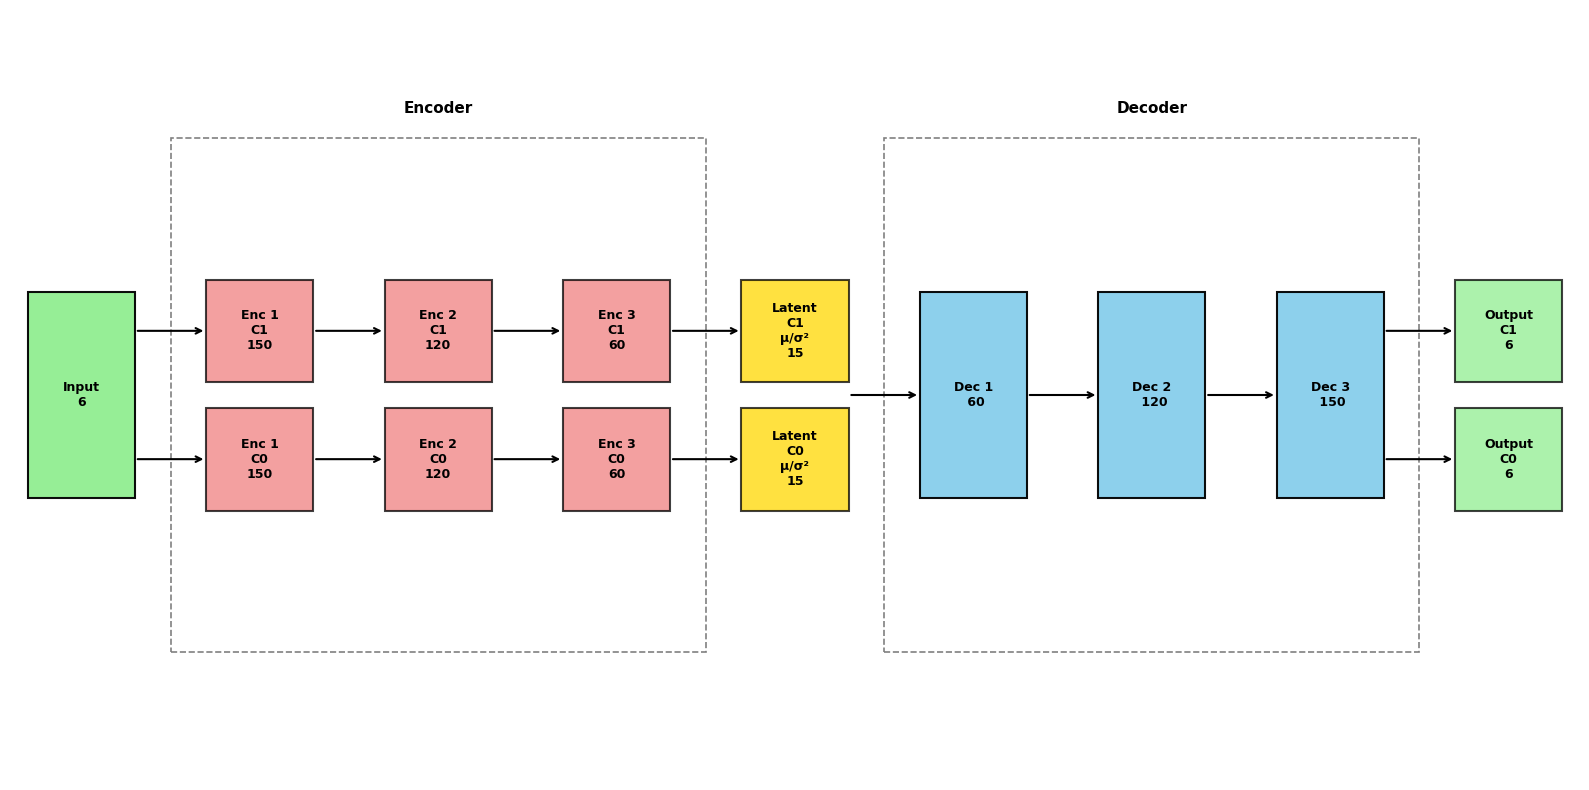

In [5]:
from ciss_vae.training.run_cissvae import run_cissvae
from ciss_vae.utils.helpers import plot_vae_architecture

prop_matrix = create_missingness_prop_matrix(
    data_wide,
    index_col="sample_id"
)

imputed_data, model = run_cissvae(
    data=data_wide.drop('sample_id', axis=1),
    missingness_proportion_matrix=prop_matrix,  # Use custom matrix
    n_clusters=2,
    scale_features=True,  # Scale the proportion matrix features
    verbose=False,
    epochs = 50
)

plot_vae_architecture(model)

# Full workflow


In [12]:
import pandas as pd
import numpy as np
from ciss_vae.utils.matrix import create_missingness_prop_matrix
from ciss_vae.utils.clustering import cluster_on_missing_prop
from ciss_vae.training.run_cissvae import run_cissvae

# 1. Create longitudinal data with complex missingness patterns
np.random.seed(42)
data = pd.DataFrame({
    'patient_id': [f'P{i:03d}' for i in range(1, 101)],
    # Glucose measurements - some patients miss early timepoints
    'glucose_baseline': np.random.normal(95, 10, 100),
    'glucose_month1': np.where(np.random.random(100) < 0.3, np.nan, np.random.normal(92, 12, 100)),
    'glucose_month3': np.where(np.random.random(100) < 0.2, np.nan, np.random.normal(90, 11, 100)),
    'glucose_month6': np.where(np.random.random(100) < 0.1, np.nan, np.random.normal(88, 10, 100)),
    # HbA1c - different missingness pattern
    'hba1c_baseline': np.where(np.random.random(100) < 0.1, np.nan, np.random.normal(6.5, 0.8, 100)),
    'hba1c_month1': np.where(np.random.random(100) < 0.4, np.nan, np.random.normal(6.3, 0.9, 100)),
    'hba1c_month3': np.where(np.random.random(100) < 0.3, np.nan, np.random.normal(6.1, 0.8, 100)),
    'hba1c_month6': np.where(np.random.random(100) < 0.2, np.nan, np.random.normal(5.9, 0.7, 100)),
})

# 2. Create missingness proportion matrix
prop_matrix = create_missingness_prop_matrix(
    data,
    index_col = "patient_id",
    repeat_feature_names = ["glucose", "hba1c"],
    nonint_timepoint=True
)

print(f"Missingness Proportion Matrix: \n{prop_matrix.head()}")

# 3. Run complete CISS-VAE pipeline
main_data = data.drop('patient_id', axis=1)

imputed_data, model, history = run_cissvae(
    data=main_data,
    missingness_proportion_matrix=prop_matrix,
    n_clusters=2,
    scale_features=True,
    epochs=100,
    verbose=False,
    return_history=True
)

print(f"\nOriginal Data: \n{main_data.head()} \n\nImputed Data:\n{imputed_data.head()}")

Missingness Proportion Matrix: 
      glucose  hba1c
P001     0.25   0.25
P002     0.50   0.25
P003     0.50   0.25
P004     0.00   0.50
P005     0.00   0.25
Cluster dataset:
 ClusterDataset(n_samples=100, n_features=8, n_clusters=2)
  • Original missing: 169 / 800 (21.12%)
  • Validation held-out: 56 (8.87% of non-missing)
  • .data shape:     (100, 8)
  • .masks shape:    (100, 8)
  • .val_data shape: (100, 8)

Original Data: 
   glucose_baseline  glucose_month1  glucose_month3  glucose_month6  hba1c_baseline  hba1c_month1  hba1c_month3  hba1c_month6
0         99.967142       92.156023             NaN       87.339202             NaN      5.859505      6.079557      5.634611
1         93.617357             NaN       78.972177             NaN        6.819309      7.239745           NaN      5.757494
2        101.476885             NaN             NaN       81.481639        6.469892           NaN      6.534880      5.492823
3        110.230299      124.642030       86.824755       88.47

## Extra tips

1. **Sample Clustering**: `cluster_on_missing_prop` clusters **samples (rows)** based on their missingness profiles across features. This groups subjects with similar patterns of missing data.
2. **Data format**: Provide the input as a matrix or DataFrame with **rows = samples** and **columns = features**. The data must be in **wide** format.
3. **Scaling**: Use `scale_features=True` if features differ greatly in their overall missingness rates. This standardizes the columns so no single feature dominates the clustering.